### Libraries & Modules

In [1]:
import os
import pathlib
import sys 
import numpy as np
import zipfile
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
sys.path.insert(0, '/srv/data/joeh97/github/SWP-2023-Automatic-Detection-of-Vibratory-Behavior-of-Honeybees' )

In [3]:
import config as cfg
from main import load_gt_items

### Load Images

In [4]:
# Load paths to all pickle files
gt_items = load_gt_items(cfg.PATH_PICKLE) 
def remap(p):
    head = pathlib.Path(cfg.PATH_IMAGES) # actual system path
    tail = p.relative_to("/mnt/curta/storage/beesbook/wdd/")  # path from pickle 
    return head.joinpath(tail) # replace path
gt_items = [tuple(item) + (remap(path),) for *item, path, in gt_items]

all_indices = np.arange(len(gt_items))
print(f"Found {len(all_indices)}  examples")
gt_items = [gt_items[i] for i in all_indices]

gt_items[:4]

Found 1009  examples


[(10902373867864485654,
  'activating',
  1.88699,
  PosixPath('/srv/data/joeh97/data/wdd_ground_truth/wdd_output_2021/cam1/2021/10/2/10/13/13/waggle.json')),
 (14315729783549168726,
  'other',
  1.74699,
  PosixPath('/srv/data/joeh97/data/wdd_ground_truth/wdd_output_2021/cam0/2021/10/3/11/6/2/waggle.json')),
 (15763256288124410364,
  'other',
  2.73699,
  PosixPath('/srv/data/joeh97/data/wdd_ground_truth/wdd_output_2021/cam1/2021/10/9/3/39/1/waggle.json')),
 (17556160191938921872,
  'trembling',
  0.09699,
  PosixPath('/srv/data/joeh97/data/wdd_ground_truth/wdd_output_2021/cam0/2021/10/2/9/44/1/waggle.json'))]

In [5]:
def load_image(f):
    img = Image.open(f)
    img = np.asarray(img, dtype=np.uint8) # uint8 important because pixels are 0-255 (2^0 - 2^8)
    return img

def load_waggle_images(waggle_path):
    '''load images from one directory (= 1 video)'''
    images = []
    waggle_dir = waggle_path.parent
    zip_file_path = os.path.join(waggle_dir, "images.zip")
    assert os.path.exists(zip_file_path) 
    with zipfile.ZipFile(zip_file_path, "r") as zf:
        image_fns = zf.namelist()
        for fn in image_fns:
            with zf.open(fn, "r") as f:
                images.append(load_image(f))
    return images

Select one specfic bee image from one specific directory

In [6]:
# select img
exmpl_path = gt_items[0][3]
exmpl_path

exmpl_imgs = load_waggle_images(exmpl_path)
exmpl_img = exmpl_imgs[0]

### Image Analysis

In [7]:
print(f'Pixel range [{np.min(exmpl_img)}, {np.max(exmpl_img)}]')

Pixel range [4, 137]


In [8]:
print(f'Shape of one image {exmpl_img.shape} pixels')

Shape of one image (220, 220) pixels


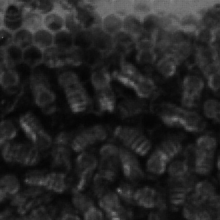

In [9]:
Image.fromarray(exmpl_img, 'L')

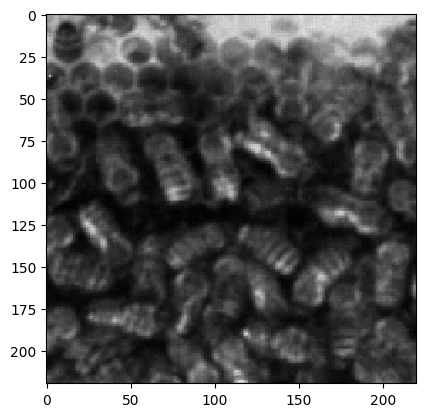

In [10]:
plt.imshow(exmpl_img, interpolation='nearest', cmap='gray')

### Image Augmentation

In [11]:
import albumentations as A

In [12]:
def show_img_vs_aug(img, imgs_aug):
    n_imgs = 1 + len(imgs_aug)

    _, ax = plt.subplots(ncols=n_imgs, nrows=1, figsize=(20,10))

    # show original image
    ax[0].imshow(img, interpolation='nearest', cmap='gray')
    ax[0].set_title("Original")
    
    # show augmented images
    for i in range(len(imgs_aug)):           
        ax[i+1].imshow(imgs_aug[i], interpolation='nearest', cmap='gray')
        ax[i+1].set_title('Augmented')


Augmenter: Downsampling resolution

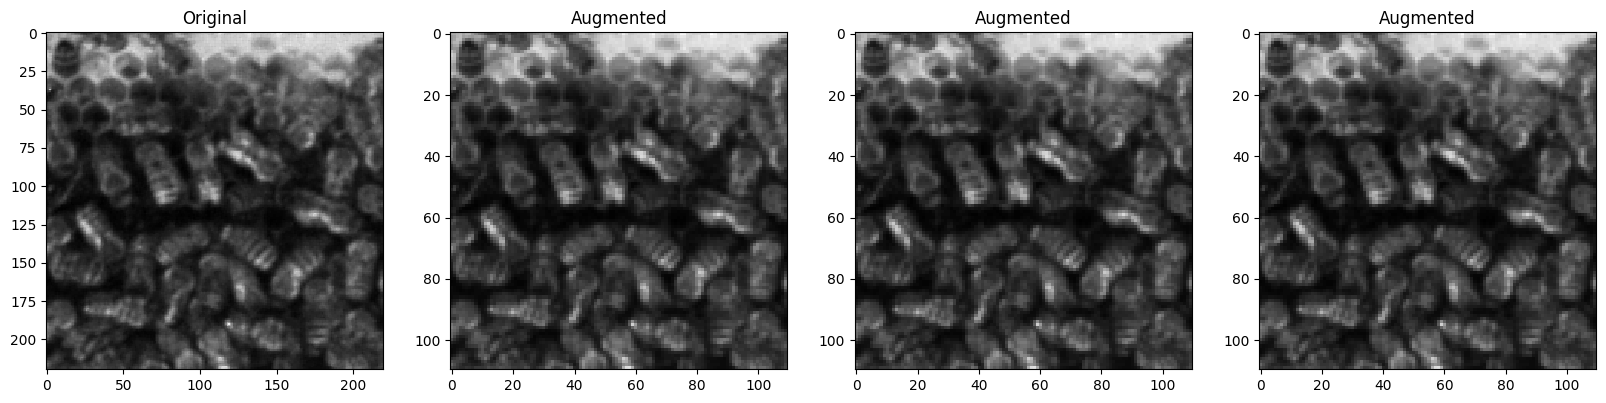

In [13]:
img_size_original = exmpl_img.shape[0]
img_size = int(img_size_original / 2)

aug_resize =  A.Compose([
    A.Resize(height=img_size, width=img_size)
])

show_img_vs_aug(img=exmpl_img, imgs_aug=[
    aug_resize(image=exmpl_img)['image'],
    aug_resize(image=exmpl_img)['image'],
    aug_resize(image=exmpl_img)['image']
])

exmpl_img = aug_resize(image=exmpl_img)['image']

Augmenter: Noise, Brightness, Contrast, Blur

/tmp/ipykernel_196935/3070716594.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(ncols=n_imgs, nrows=1, figsize=(20,10))


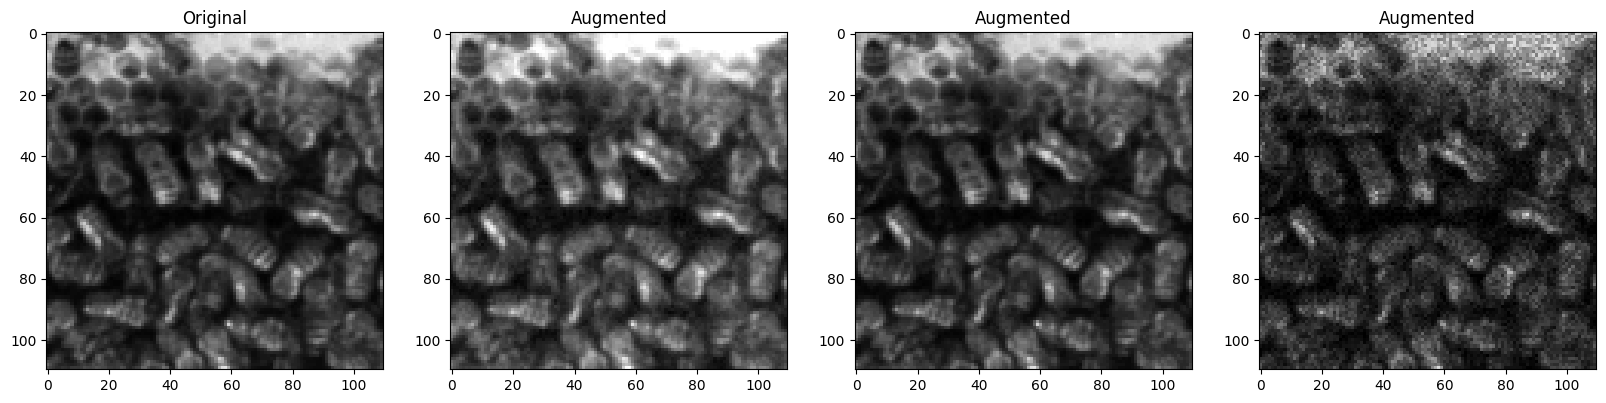

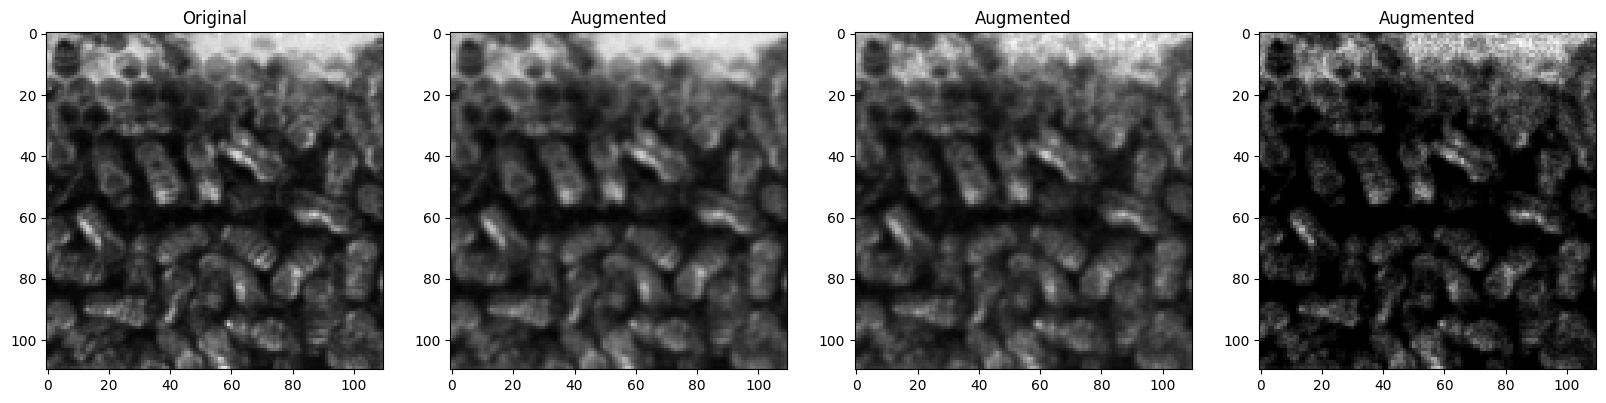

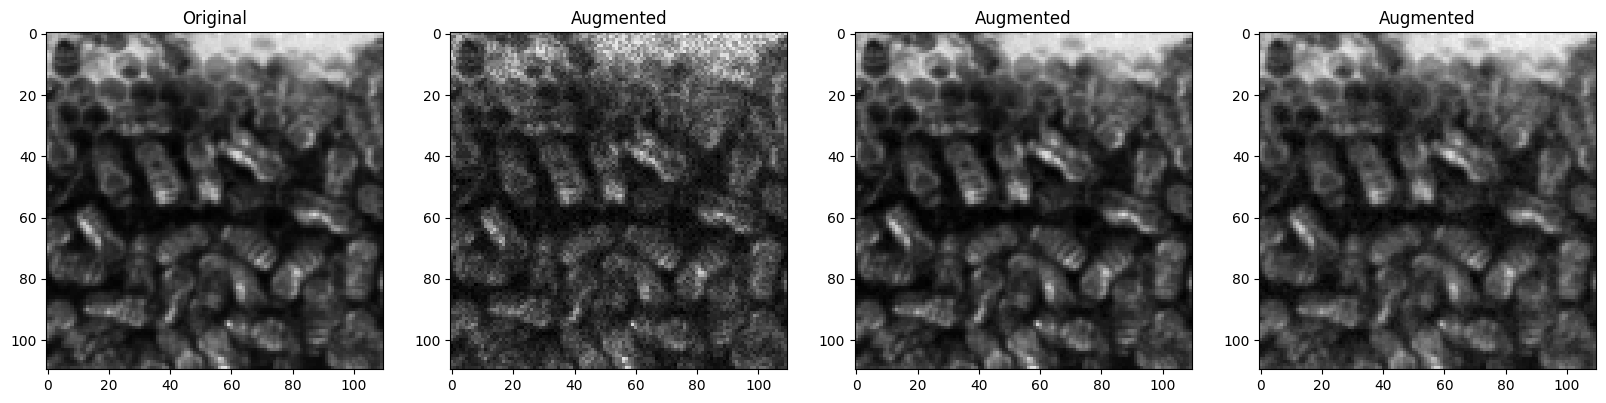

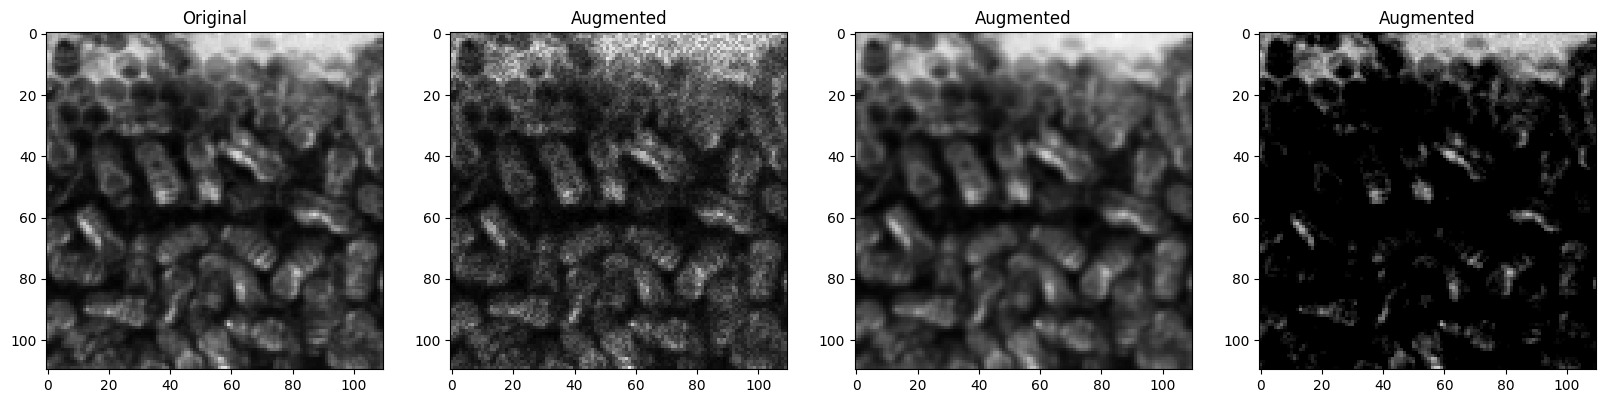

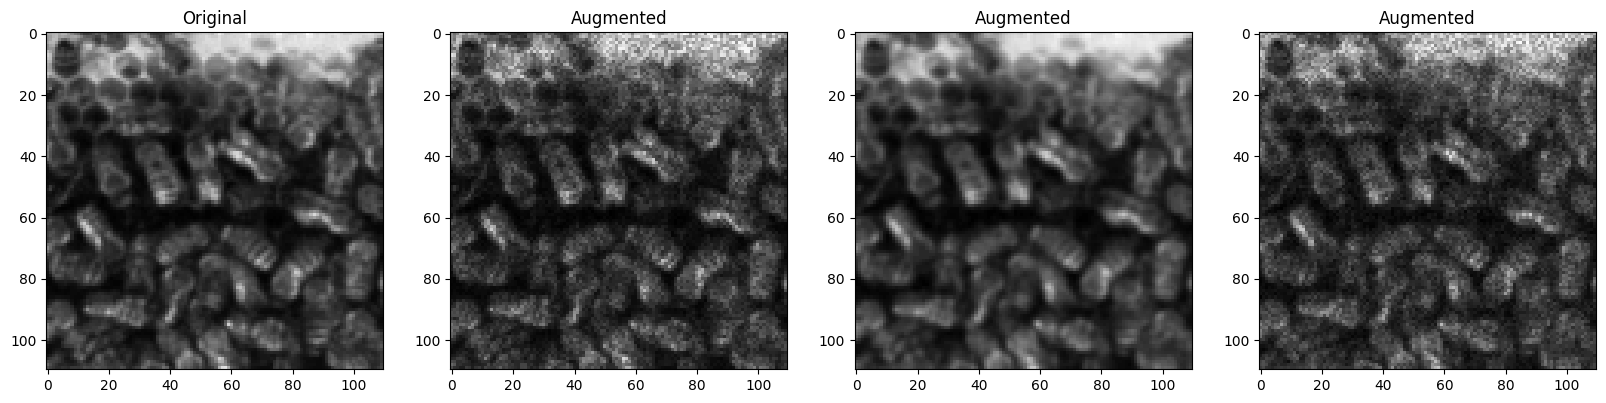

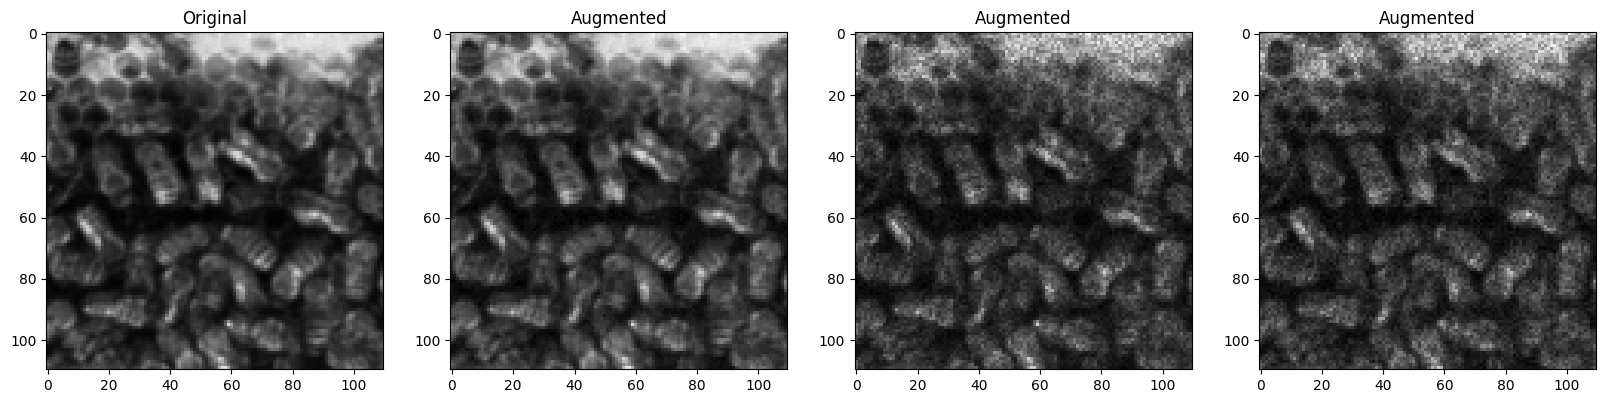

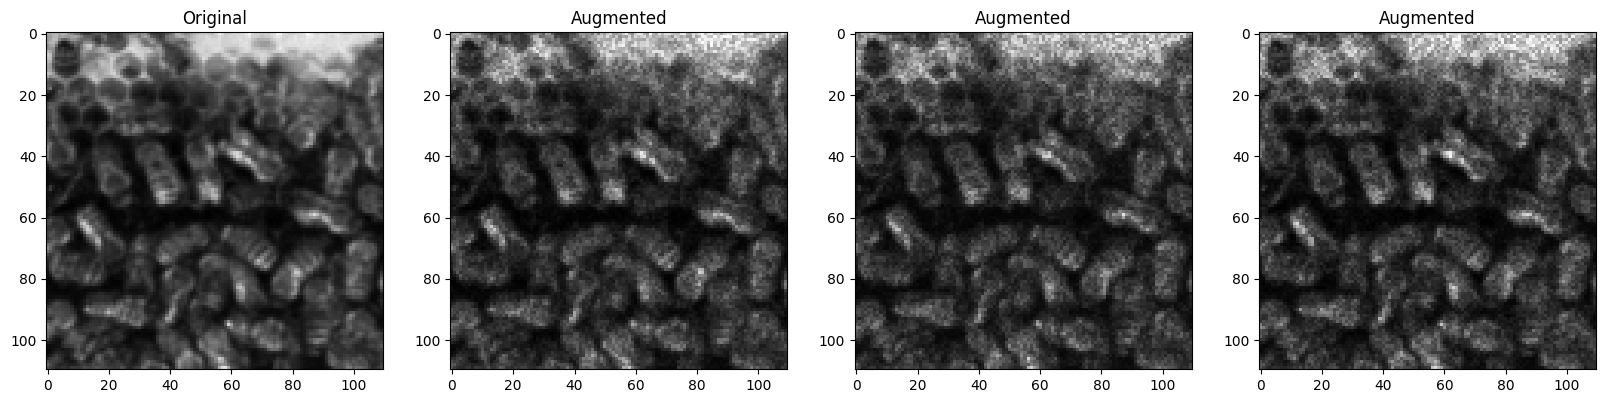

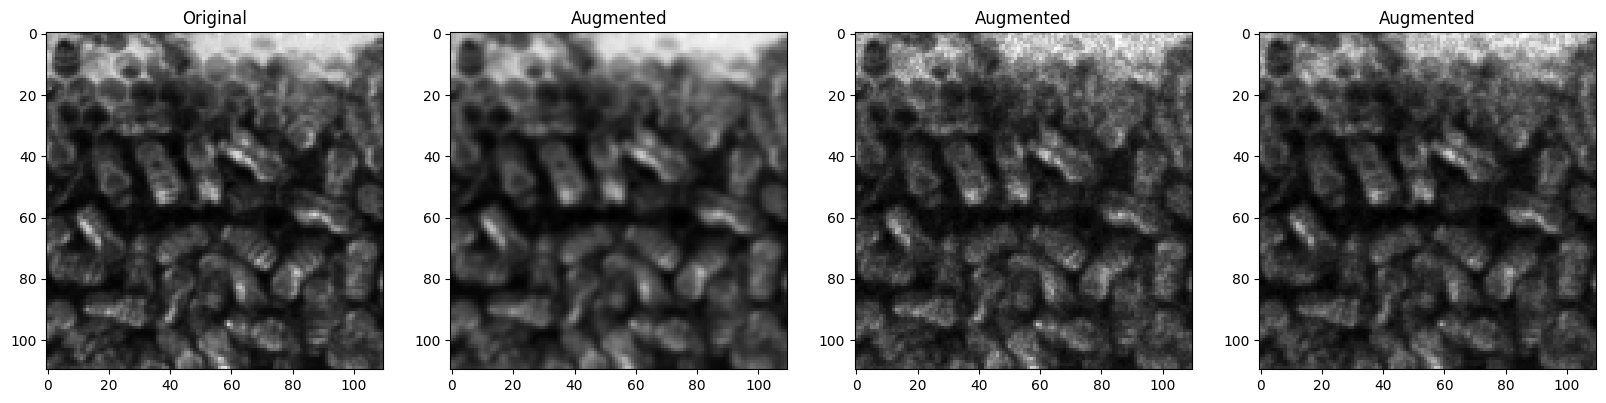

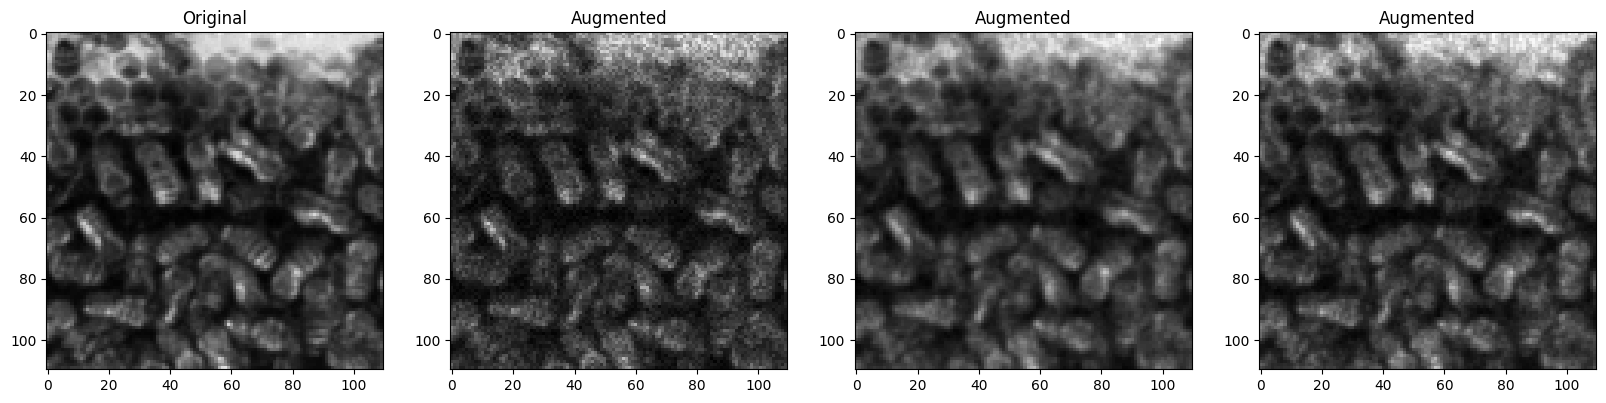

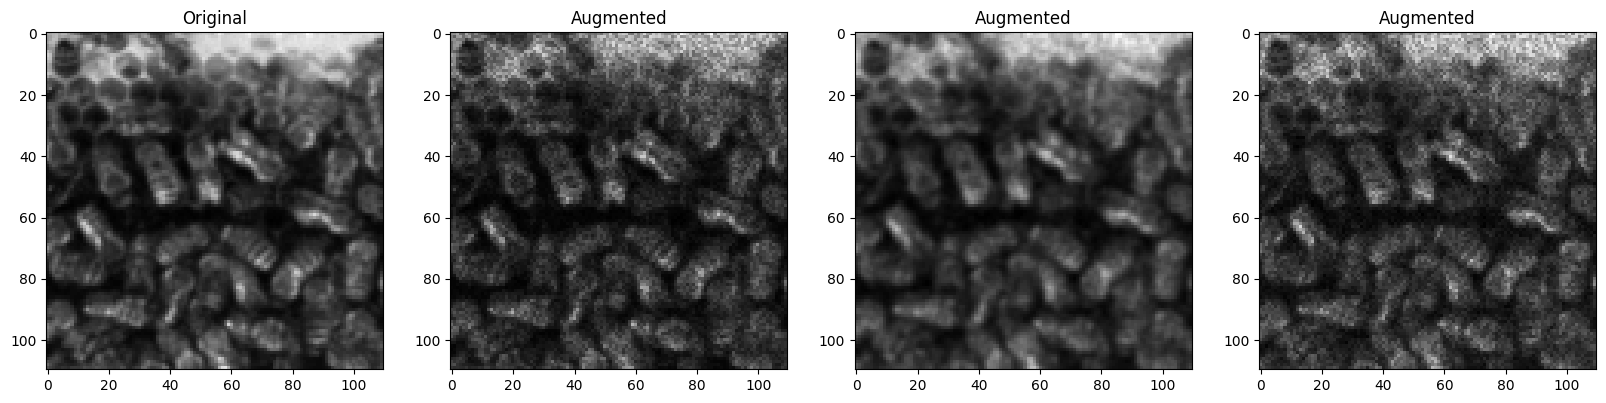

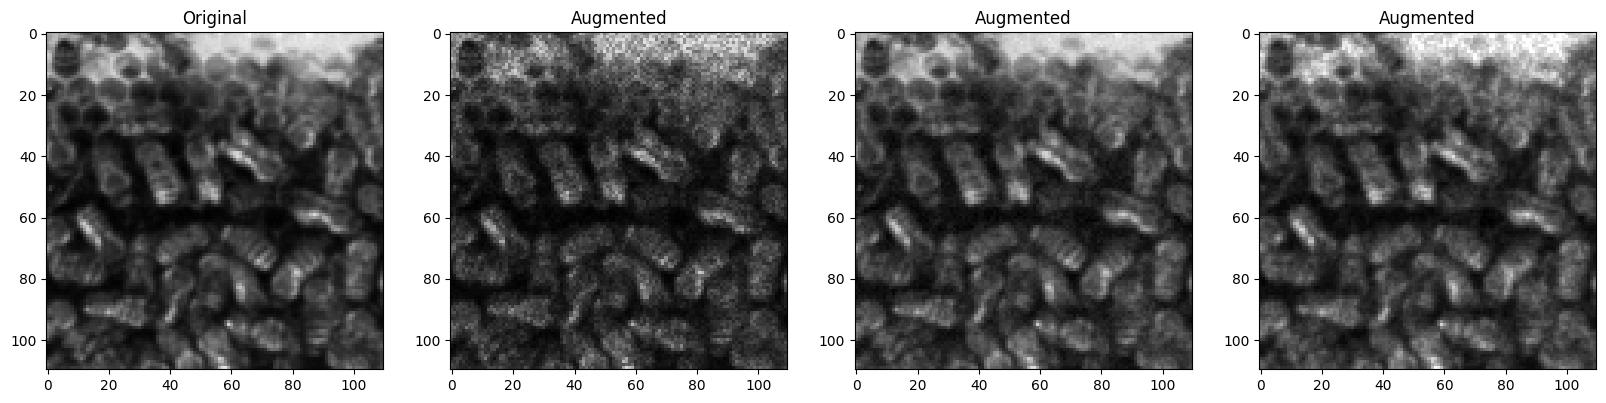

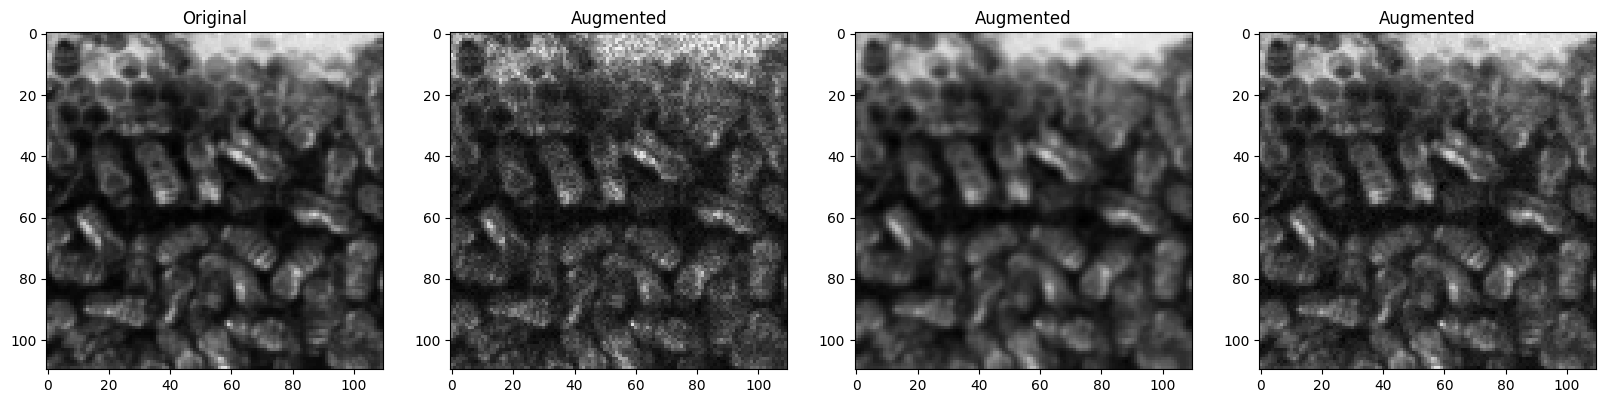

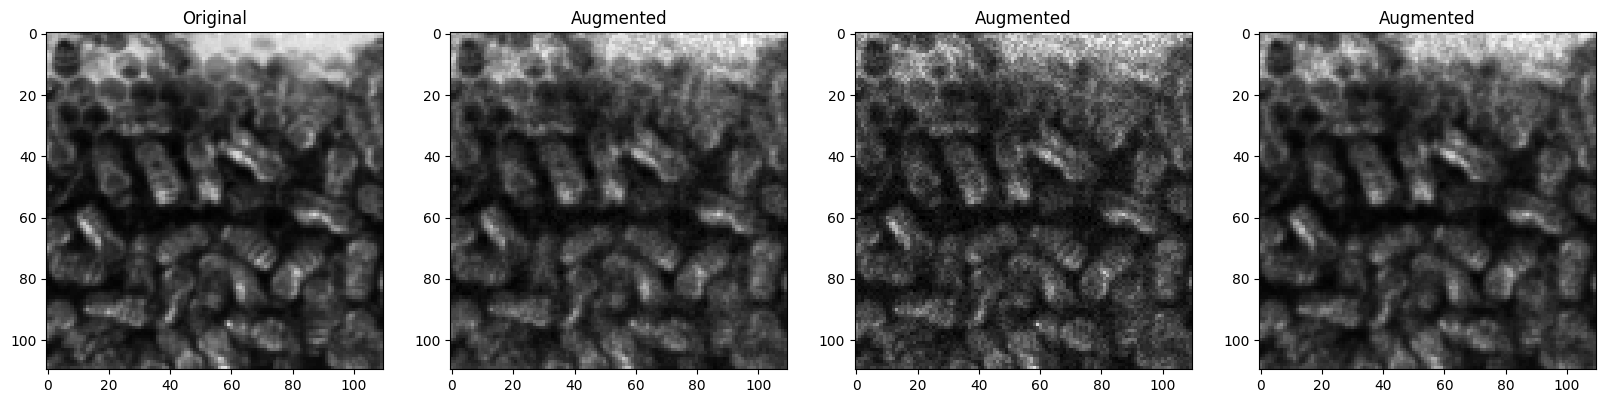

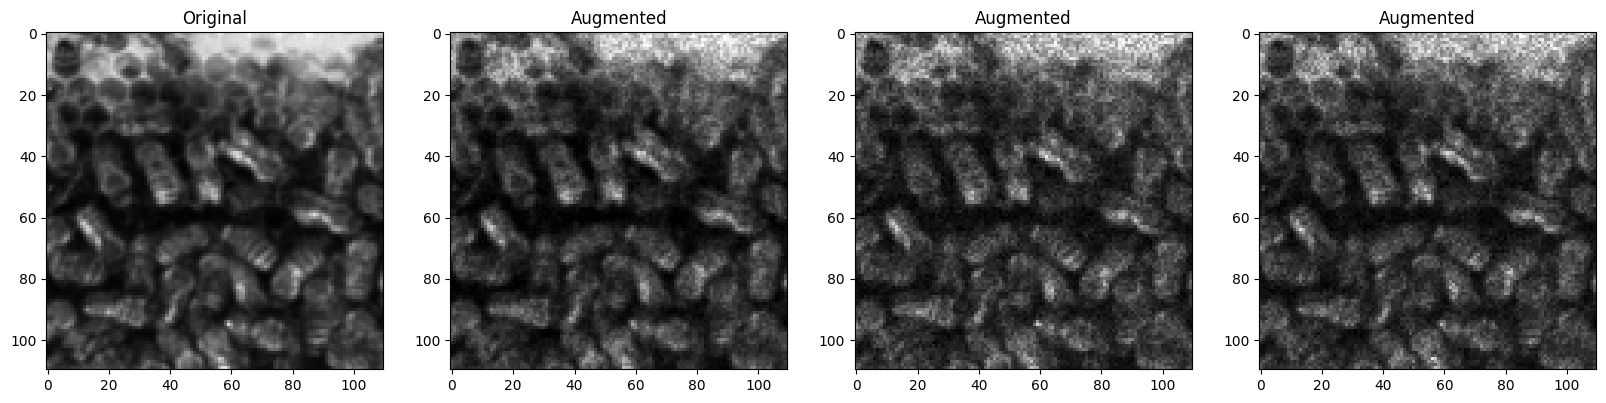

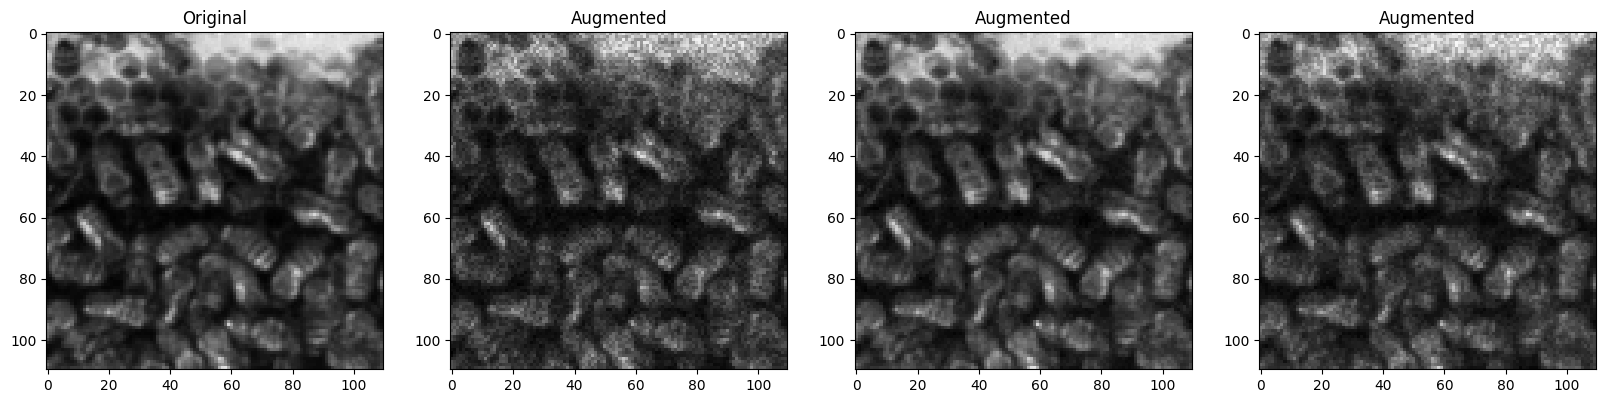

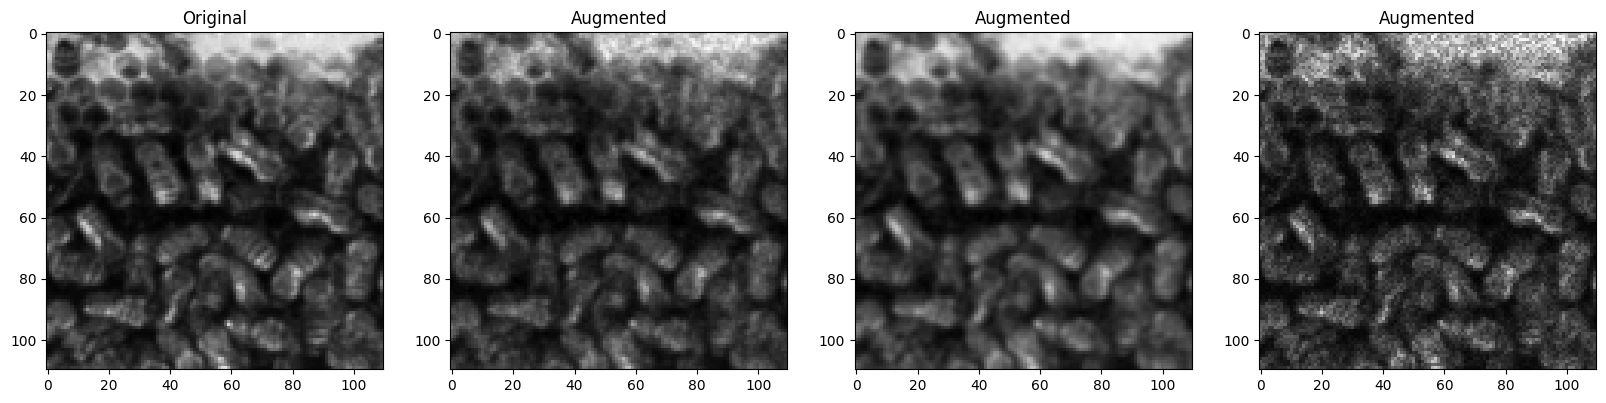

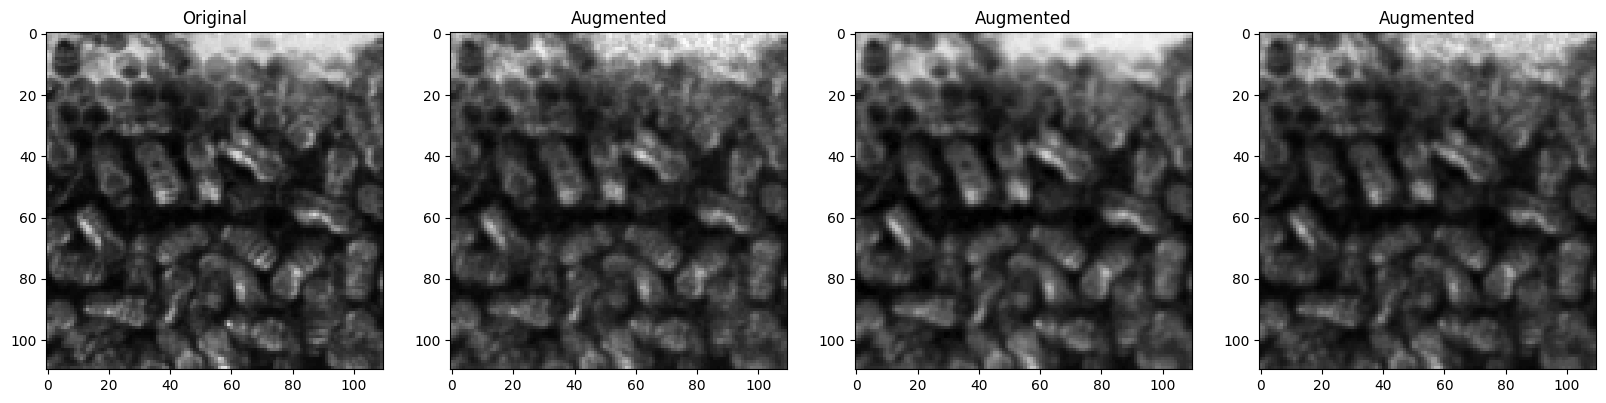

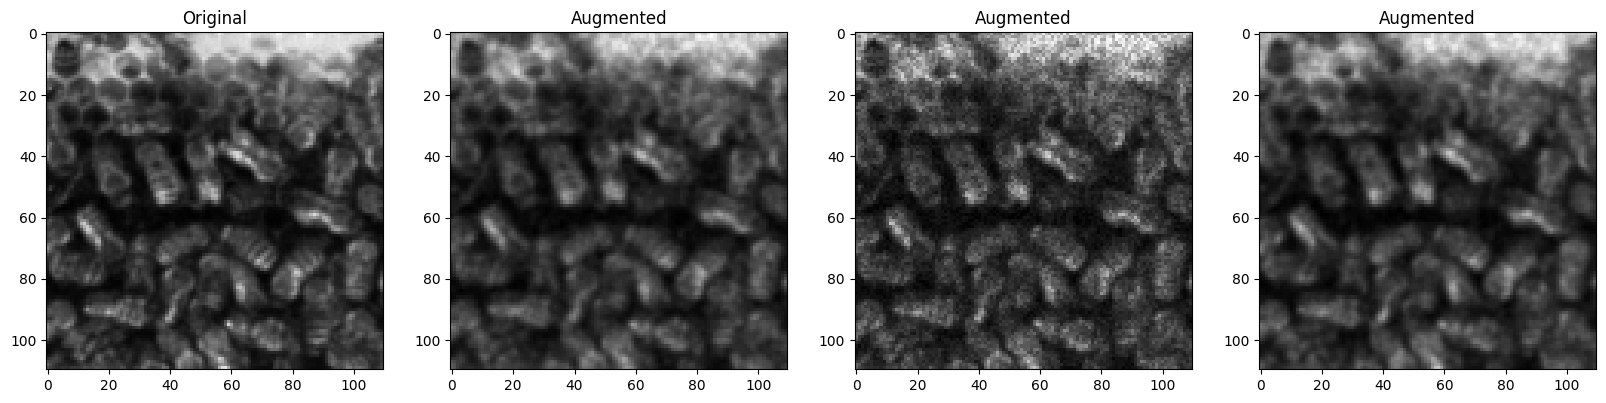

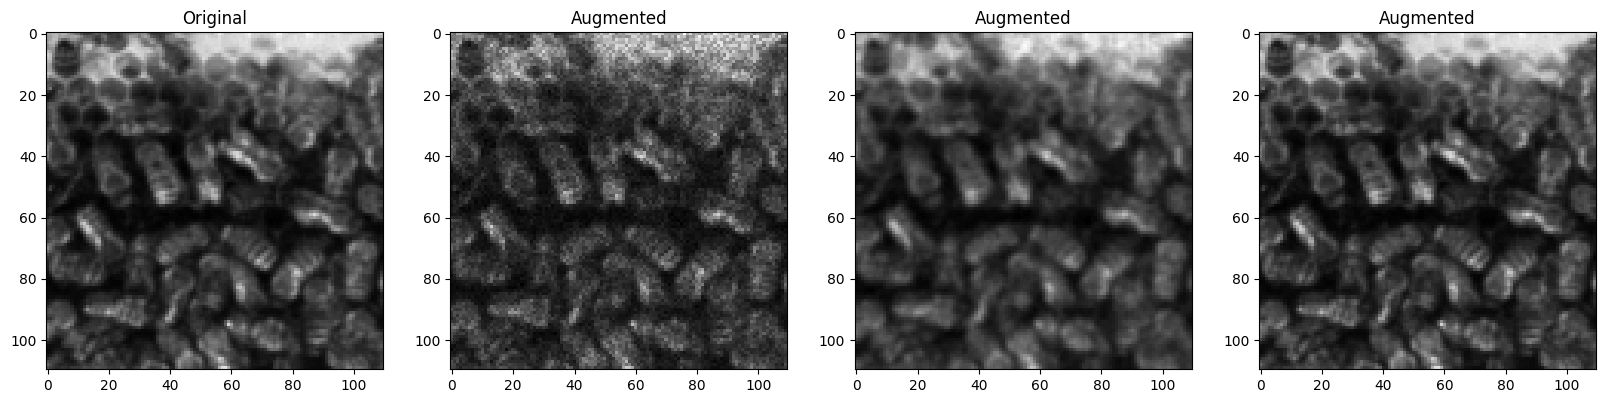

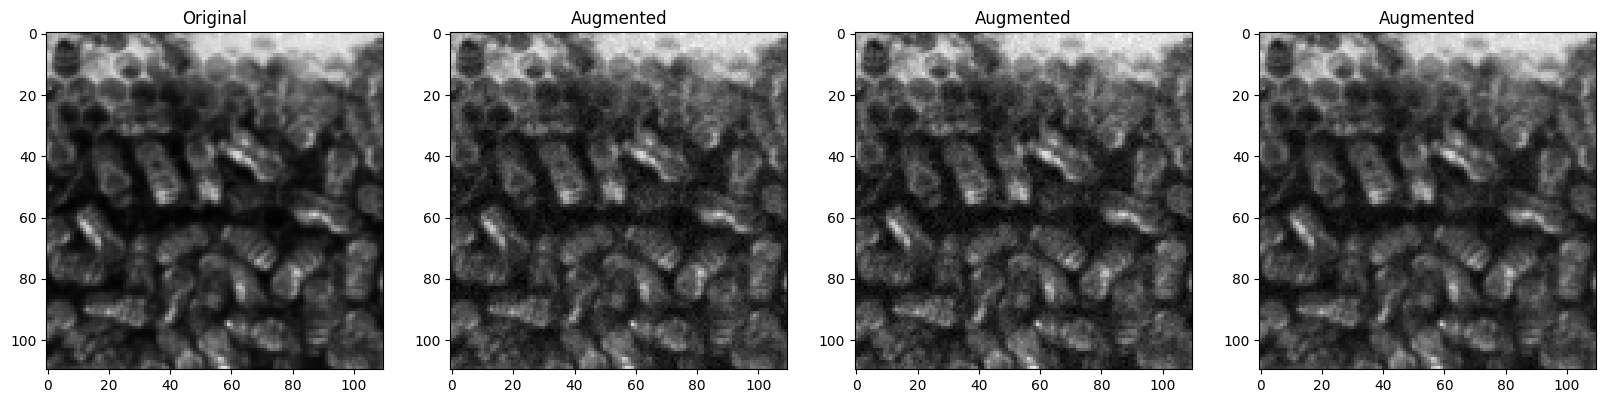

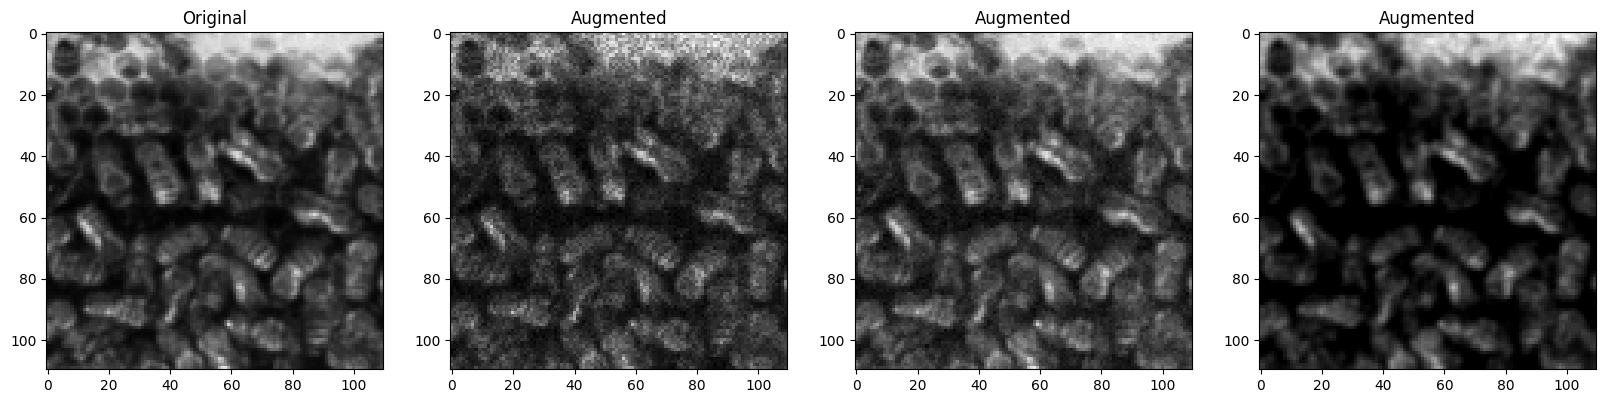

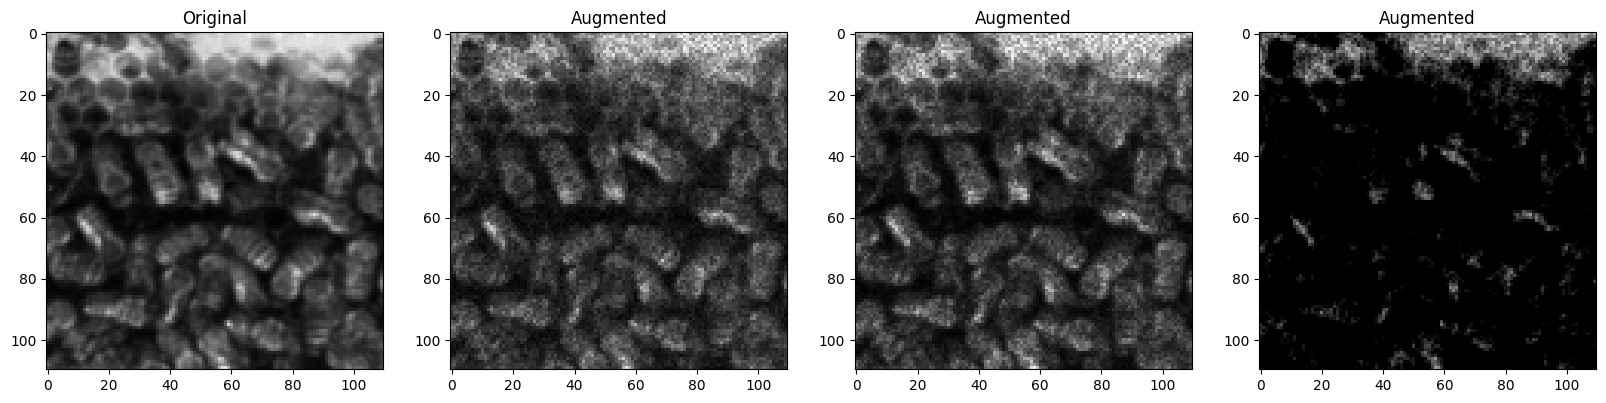

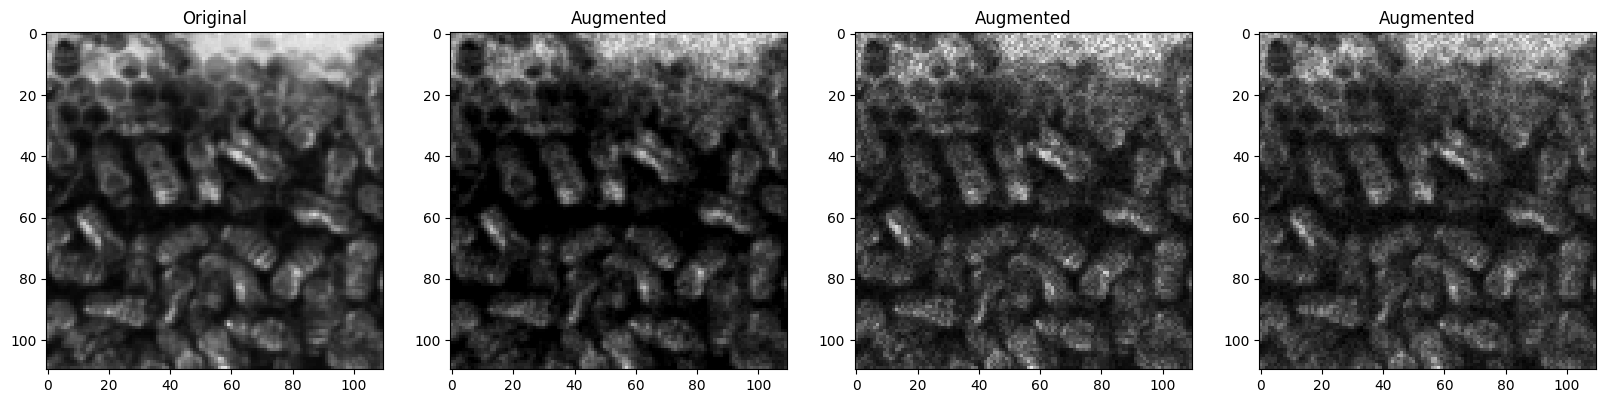

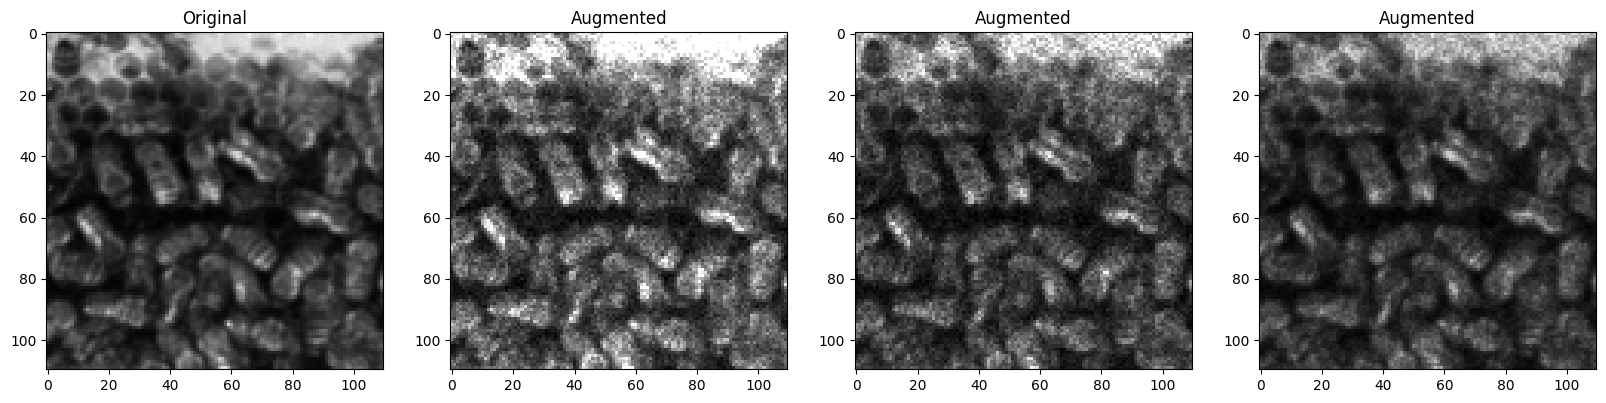

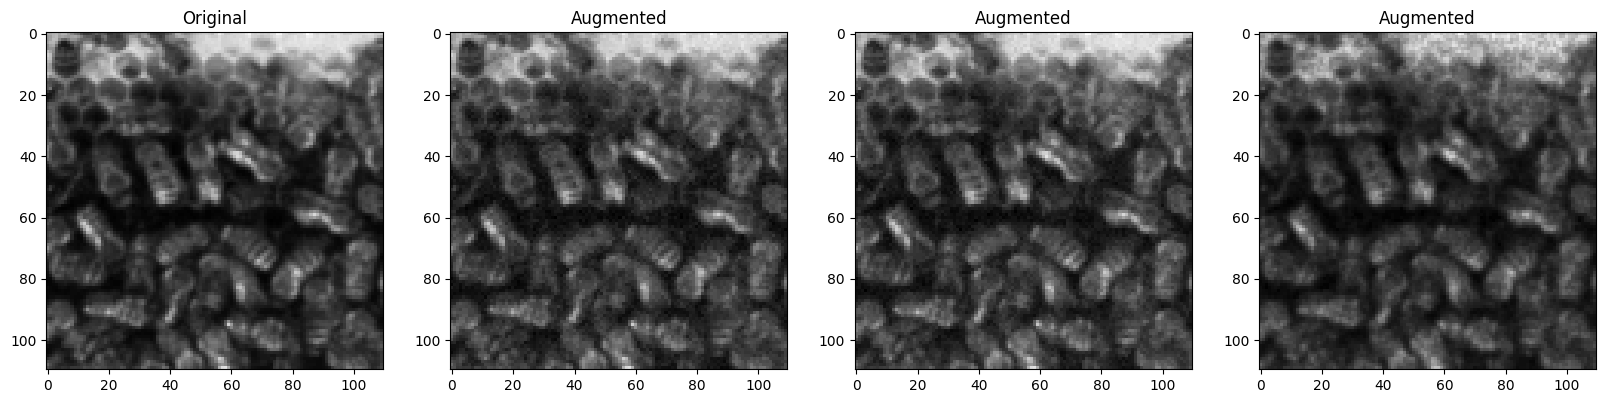

In [51]:
p = 0.75
aug_noise = A.Compose([
    # A.MultiplicativeNoise() --- produces lighter/darker image
    #
    # `arg multiplier(a,b)`
    #   value p is multiplied by a unique value v which is in the range of
    #   multiplier=(a, b).
    #   v < 1 --> p' is darker than p
    #   v > 1 --> p' is lighter than p
    # 
    # `arg elementwise=True` 
    #   True --> each pixel p uses different factor v to create p'=p*v 
    A.MultiplicativeNoise(p=p, multiplier=(0.75, 1.25), elementwise=True),

    # A.GaussNoise() --- produces noisy image
    #
    # `arg var_limit(a, b)`
    #   defines range for variance (randomly sampled), where a is min and b is max
    A.GaussNoise(p=p, var_limit=(0, 10)),

    # A.GaussianBlur() --- produces blurry image
    #
    # `arg sigma_limit(a, b)`
    #   defines range for blur, where a is min and b is max
    A.GaussianBlur(p=p, sigma_limit=(0.0, 0.75), always_apply=True),

    # A.RandomBrightnessContrast() --- affects brightness (light/dark) and contrast
    #
    # `arg brightness_limit(a, b)`
    #   defines range for brightness, where a is min and b is max
    #
    # `arg contrast_limit(a, b)`
    #   defines range for contrast_limit, where a is min and b is max
    A.RandomBrightnessContrast(p=p, brightness_limit=(-0.1, 0.5), contrast_limit=(-0.5, 0.5))
])


for i in range(25):
    show_img_vs_aug(img=exmpl_img, imgs_aug=[
    aug_noise(image=exmpl_img)['image'],
    aug_noise(image=exmpl_img)['image'],
    aug_noise(image=exmpl_img)['image']
    ])

